In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

from transformers import BertTokenizer
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics

# EDA

In [2]:
df = pd.read_csv('data_text/news.csv')

In [3]:
df.head(2)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE


In [4]:
df['text'] = df['text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x).rstrip())

In [5]:
labels = {'REAL':1, 'FAKE': 0}
df['label'] = df['label'].apply(lambda x: labels[x])

In [6]:
df.head(2)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield a Shillman Journalism Fellow...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0


<BarContainer object of 2 artists>

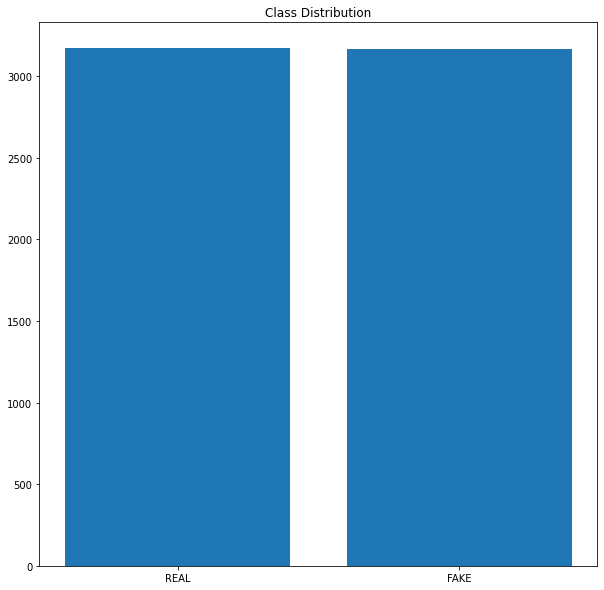

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Class Distribution')
plt.bar(
    ['REAL', 'FAKE'],
    df['label'].value_counts().values
)

# Build Dataset

In [8]:
text = df['text'].tolist()
labels = df['label'].tolist()

In [9]:
train_text, valid_text, train_label, valid_label = train_test_split(text, labels, stratify=labels, random_state=2021, test_size=0.3)
valid_text, test_text, valid_label, test_label = train_test_split(valid_text, valid_label, stratify=valid_label, random_state=2021, test_size=0.5)

In [10]:
# Load tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
class FakeNewsDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length=350):
        self.tokenizer = tokenizer
        self.text = text
        self.labels = labels
        self.max_length = max_length
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        label = self.labels[index]
        
        inputs = self.tokenizer.encode_plus(
            text, padding='max_length', 
            max_length=self.max_length, truncation=True, 
            return_tensors='pt', add_special_tokens=True
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'token_type_ids': inputs['token_type_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
# Lets build with pl datamodule
class FakeNewsDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        train_text, valid_text, test_text,
        train_label, valid_label, test_label,
        tokenizer, batch_size=32, max_length=300
    ):
        super(FakeNewsDataModule, self).__init__()
        
        self.train_text = train_text
        self.train_label = train_label
        self.valid_text = valid_text
        self.valid_label = valid_label
        self.test_text = test_text
        self.test_label = test_label
        
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        
    def setup(self, stage=None):
        self.train_dataset = FakeNewsDataset(
            self.train_text, self.train_label, self.tokenizer, self.max_length
        )
        
        self.valid_dataset = FakeNewsDataset(
            self.valid_text, self.valid_label, self.tokenizer, self.max_length
        )
        
        self.test_dataset = FakeNewsDataset(
            self.test_text, self.test_label, self.tokenizer, self.max_length
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=6
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=6
        )
    
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=6
        )

In [13]:
epochs = 10
batch_size = 8

data_module = FakeNewsDataModule(
    train_text, valid_text, test_text,
    train_label, valid_label, test_label,
    tokenizer, batch_size
)

# Build Model

In [14]:
class FakeNewClassifier(pl.LightningModule):
    def __init__(self, n_classes=2):
        super(FakeNewClassifier, self).__init__()
        
        self.n_classes = n_classes
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, 256)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.25)
        self.classifier = nn.Linear(256, n_classes)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        embeddings = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )[1]
        
        embeddings = self.dropout(embeddings)
        embeddings = self.fc(embeddings)
        embeddings = self.gelu(embeddings)
        embeddings = self.classifier(embeddings)
        
        return embeddings
    
    
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask, token_type_ids)
        loss = self.criterion(logits, labels)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask, token_type_ids)
        loss = self.criterion(logits, labels)
        accuracy = torchmetrics.functional.accuracy(logits.argmax(dim=1), labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', accuracy, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_acc': accuracy}
    
    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        logits = self(input_ids, attention_mask, token_type_ids)
        
        accuracy = torchmetrics.functional.accuracy(logits.argmax(dim=1), labels)
        auc = torchmetrics.functional.auc(logits.argmax(dim=1), labels, reorder=True)
        conf_mat = torchmetrics.functional.confusion_matrix(logits.argmax(dim=1), labels, num_classes=self.n_classes)
        mcc = torchmetrics.functional.matthews_corrcoef(logits.argmax(dim=1), labels, num_classes=self.n_classes)
        
        self.log('test_auc', auc, prog_bar=True, logger=True)
        self.log('test_acc', accuracy, prog_bar=True, logger=True)
        self.log('test_conf_mat', conf_mat, prog_bar=True, logger=True)
        self.log('test_mcc', mcc, prog_bar=True, logger=True)
        
        return {'acc':accuracy, 'auc':auc, 'conf_mat': conf_mat, 'mcc': mcc}
    
    def configure_optimizers(self):
        optimizer = AdamW(model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=20, num_training_steps=100
        )
        
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [15]:
model = FakeNewClassifier()
model.summarize()


  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 109 M 
1 | fc         | Linear           | 196 K 
2 | gelu       | GELU             | 0     
3 | dropout    | Dropout          | 0     
4 | classifier | Linear           | 514   
5 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.718   Total estimated model params size (MB)


  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 109 M 
1 | fc         | Linear           | 196 K 
2 | gelu       | GELU             | 0     
3 | dropout    | Dropout          | 0     
4 | classifier | Linear           | 514   
5 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.718   Total estimated model params size (MB)

In [16]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoints',
    save_top_k=1,
    verbose=True,
    monitor="val_acc",
    mode="min"
)

early_stopping = EarlyStopping(monitor='val_acc', patience=2)

In [17]:
trainer = pl.Trainer(
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping],
    max_epochs=epochs,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [18]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 109 M 
1 | fc         | Linear           | 196 K 
2 | gelu       | GELU             | 0     
3 | dropout    | Dropout          | 0     
4 | classifier | Linear           | 514   
5 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.718   Total estimated model params size (MB)


In [19]:
trainer.test(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8843322992324829,
 'test_auc': 0.5005257725715637,
 'test_conf_mat': 1.9978992938995361,
 'test_mcc': 0.7732845544815063}
--------------------------------------------------------------------------------


[{'test_auc': 0.5005257725715637,
  'test_acc': 0.8843322992324829,
  'test_conf_mat': 1.9978992938995361,
  'test_mcc': 0.7732845544815063}]

# Evaluation

In [20]:
model.to('cuda')
model.eval()

FakeNewClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [21]:
y_pred = []

for batch in data_module.test_dataloader():
    input_ids = batch['input_ids'].to('cuda')
    token_type_ids = batch['token_type_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['labels']
    
    with torch.no_grad():
        preds = model(input_ids, attention_mask, token_type_ids)
        
    preds = F.softmax(preds, dim=-1)
    preds = preds.detach().cpu().numpy()
    
    y_pred.append(preds)

y_pred = np.concatenate(y_pred).argmax(axis=1)

In [22]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       475
           1       0.88      0.89      0.89       476

    accuracy                           0.88       951
   macro avg       0.88      0.88      0.88       951
weighted avg       0.88      0.88      0.88       951



<AxesSubplot:>

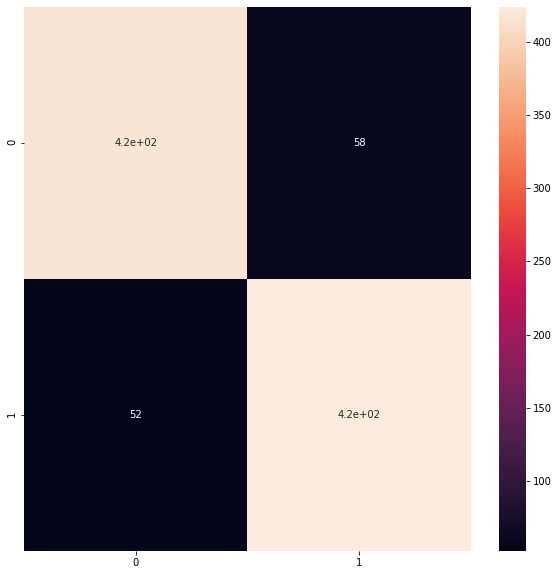

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(test_label, y_pred), annot=True)

In [24]:
matthews_corrcoef(test_label, y_pred)

0.768722441048273

# Inference

In [25]:
index_label = {
    1: 'REAL',
    0: 'FAKE'
}

In [26]:
text = test_text[0]

In [27]:
text.split()[:5]

['Shortly', 'after', 'Barack', 'Obama', 's']

In [28]:
inputs = tokenizer.encode_plus(
    text, padding='max_length', 
    max_length=350, truncation=True, 
    return_tensors='pt', add_special_tokens=True
)

In [29]:
model.eval()
with torch.no_grad():
    preds = model(
        inputs['input_ids'].to('cuda'), inputs['attention_mask'].to('cuda'), 
        inputs['token_type_ids'].to('cuda')
    )

In [30]:
preds = F.softmax(preds, dim=1)
preds = preds.detach().cpu().numpy()

In [31]:
preds = np.squeeze(preds, axis=0)

In [32]:
print('News is {}, with a probability of {}%'.format(index_label[preds.argmax()], round(preds.max() * 100, 2)))

News is REAL, with a probability of 78.89%
